In [1]:
import os
import numpy as np
import cv2
import torch

import jax.numpy as jnp

100.0%


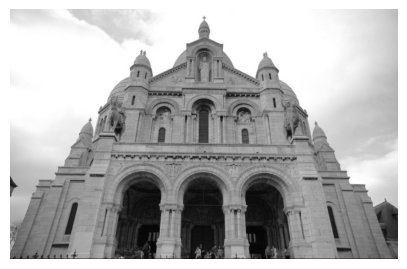

In [2]:
# Download image from URL.
image_url = 'https://raw.githubusercontent.com/cvg/Hierarchical-Localization/master/datasets/sacre_coeur/mapping/03903474_1471484089.jpg'
image_path = 'image_sacre_coeur.jpg'
torch.hub.download_url_to_file(image_url, image_path)

# For plotting, assume you have a helper function. Here we use matplotlib.
import matplotlib.pyplot as plt

def plot_imgs(imgs, cmap=None):
    """Simple helper to plot a list of images."""
    n = len(imgs)
    plt.figure(figsize=(5*n, 5))
    for i, img in enumerate(imgs):
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')
    plt.show()

# Read the image with OpenCV, convert to grayscale and normalize.
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Failed to read image from " + image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

# Pad image so that its dimensions are multiples of 8.
padded = []
for s in image_gray.shape:
    pad = int(np.ceil(s/8)*8 - s)
    padded.append((0, pad))
image_padded = np.pad(image_gray, padded, mode='constant')
plot_imgs([image_padded], cmap='gray')

In [3]:
from superpoint_jax import SuperPointTorch

# Instantiate the PyTorch model.
torch_model = SuperPointTorch()
# Load the pretrained weights (assumes a file named 'superpoint_torch_weights.pth' exists).
torch_checkpoint = "../weights/superpoint_torch.pth"
if not os.path.exists(torch_checkpoint):
    raise FileNotFoundError(f"PyTorch checkpoint {torch_checkpoint} not found.")
torch_state = torch.load(torch_checkpoint, map_location="cpu")
torch_model.load_state_dict(torch_state)
torch_model.eval()
print("Loaded PyTorch SuperPoint model.")

Loaded PyTorch SuperPoint model.


/tmp/ipykernel_9443/4165455927.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_state = torch.load(torch_checkpoint, map_location="cpu")


In [4]:
from superpoint_jax import SuperPointJAX
from superpoint_jax.utils import convert_superpoint_weights
from flax.serialization import to_bytes, from_bytes
from flax import nnx

# Create the JAX model with the same configuration as the torch model.
jax_model = SuperPointJAX(rngs=nnx.Rngs(0))
print("Created JAX SuperPoint model.")

# Convert weights: this copies parameters from the torch model into the jax model.
jax_model = convert_superpoint_weights(torch_model, jax_model)
print("Converted PyTorch weights to JAX.")

Created JAX SuperPoint model.
Converted PyTorch weights to JAX.


In [5]:
dummy_torch = torch.from_numpy(image_padded[None, None, ...]).float()  # add batch and channel dims
dummy_jax = jnp.array(image_padded[None, ..., None], dtype=jnp.float32)

# --- Run the Torch model forward pass ---
with torch.no_grad():
    torch_output = torch_model.forward({"image": dummy_torch})
# torch_output is a dict with keys "keypoints", "keypoint_scores", "descriptors"
num_keypoints_torch = [k.shape[0] for k in torch_output["keypoints"]]
print("PyTorch detected keypoints:", num_keypoints_torch)

# --- Run the JAX model forward pass ---
jax_output = jax_model(dummy_jax, training=False)
# jax_output is a dict with keys "keypoints", "scores", "descriptors", "valid_counts"
if "valid_counts" in jax_output:
    num_keypoints_jax = int(jax_output["valid_counts"][0])
else:
    num_keypoints_jax = int(jnp.sum(jnp.where(jax_output["scores"] > -1, 1, 0)))
print("JAX detected keypoints (approx):", num_keypoints_jax)

PyTorch detected keypoints: [3203]
JAX detected keypoints (approx): 3203


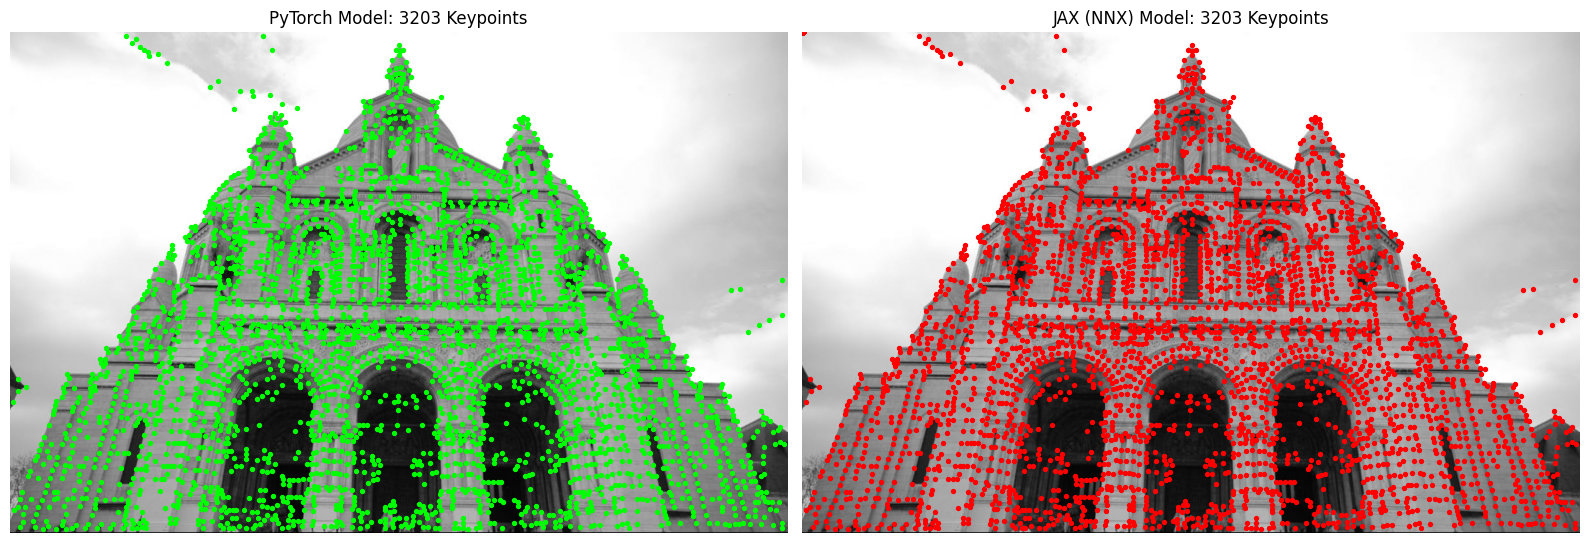

In [6]:
import matplotlib.pyplot as plt
import numpy as np

torch_kpts = torch_output["keypoints"][0].cpu().numpy()  # shape (N, 2)
jax_kpts = np.array(jax_output["keypoints"][0])  # shape (N, 2)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(image_padded, cmap="gray")
if torch_kpts.size > 0:
    axs[0].scatter(torch_kpts[:, 0], torch_kpts[:, 1], s=8, c='lime', marker='o')
axs[0].set_title(f"PyTorch Model: {torch_kpts.shape[0]} Keypoints")
axs[0].axis("off")

axs[1].imshow(image_padded, cmap="gray")
if jax_kpts.size > 0:
    axs[1].scatter(jax_kpts[:, 1], jax_kpts[:, 0], s=8, c='red', marker='o')
axs[1].set_title(f"JAX (NNX) Model: { int(jax_output['valid_counts'][0]) } Keypoints")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In [7]:
jax_state = nnx.state(jax_model).to_pure_dict()

jax_save_path = "../weights/superpoint_nnx.msgpack"
with open(jax_save_path, "wb") as f:
    f.write(to_bytes(jax_state))
print(f"Saved JAX model state to {jax_save_path}")

Saved JAX model state to ../weights/superpoint_nnx.msgpack


Reloaded JAX model with saved state.
JAX model output keys: ['keypoints', 'scores', 'descriptors', 'valid_counts']
Valid keypoints count: [3203]


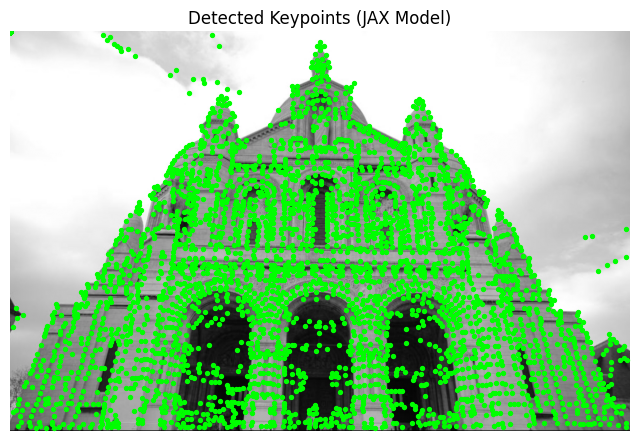

In [8]:
with open(jax_save_path, "rb") as f:
    loaded_state = from_bytes(jax_state, f.read())

jax_model_reloaded = SuperPointJAX(rngs=nnx.Rngs(0))
# Update the model with the loaded state.
nnx.update(jax_model_reloaded, loaded_state)
print("Reloaded JAX model with saved state.")

# Prepare the image for JAX: image_padded is already normalized.
input_jax = jnp.array(image_padded[None, ..., None], dtype=jnp.float32)
# Run the model.
jax_result = jax_model_reloaded(input_jax, training=False)
print("JAX model output keys:", list(jax_result.keys()))
print("Valid keypoints count:", jax_result.get("valid_counts", "Not provided"))

keypoints = jax_result["keypoints"][0]  # shape (N, 2)
keypoints = np.array(keypoints)  # convert from jax DeviceArray to numpy

plt.figure(figsize=(8, 6))
plt.imshow(image_padded, cmap="gray")
if keypoints.size > 0:
    plt.scatter(keypoints[:, 1], keypoints[:, 0], s=8, c="lime", marker="o")
plt.title("Detected Keypoints (JAX Model)")
plt.axis("off")
plt.show()